In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [3]:
path_base = '../data/B_Cell/'
path_filtered = path_base + '01_filtered_tcr_10x.h5ad'
path_anno = path_base + '02_annoated.h5ad'

## Merge Files

The 10x VDJ dataset consists of CD8+ T cells from for donor. First, transcriptome data is merged with tcr information. In a second step, the data is fused over all donors. In the third step, the measured binding affinity is merged.

In [4]:
adatas = []
batch_names = ['pre', 'post']

for state in batch_names:
    # Transcriptome data
    file_name = path_base + f'raw/sc5p_v2_hs_B_{state}vax_10k_5gex_B_count_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)

    # TCR data
    path_anno = path_base + f'raw/sc5p_v2_hs_B_{state}vax_10k_5gex_B_vdj_b_filtered_contig_annotations.csv'
    anno_tcr = ir.io.read_10x_vdj(path_anno)    
    ir.pp.merge_with_ir(adata_tmp, anno_tcr)
    
    adata_tmp.obs_names_make_unique()
    adata_tmp.var_names_make_unique()
    
    
    adatas.append(adata_tmp)
    
adata = adatas[0].concatenate(adatas[1:], batch_key='state', batch_categories=batch_names)

reading ../data/B_Cell/raw/sc5p_v2_hs_B_prevax_10k_5gex_B_count_filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
reading ../data/B_Cell/raw/sc5p_v2_hs_B_postvax_10k_5ge

In [5]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 18115
With IR-Info: 17109


# Qualitiy control

Load data and calculate the amount of counts, genes and fraction of mitochondrial genes.

In [6]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VDJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_d_gene' as categorical
... storing 'IR_VDJ_2_d_gene' as categorical
... storing 'IR_VJ_1_j_gene' as categorical


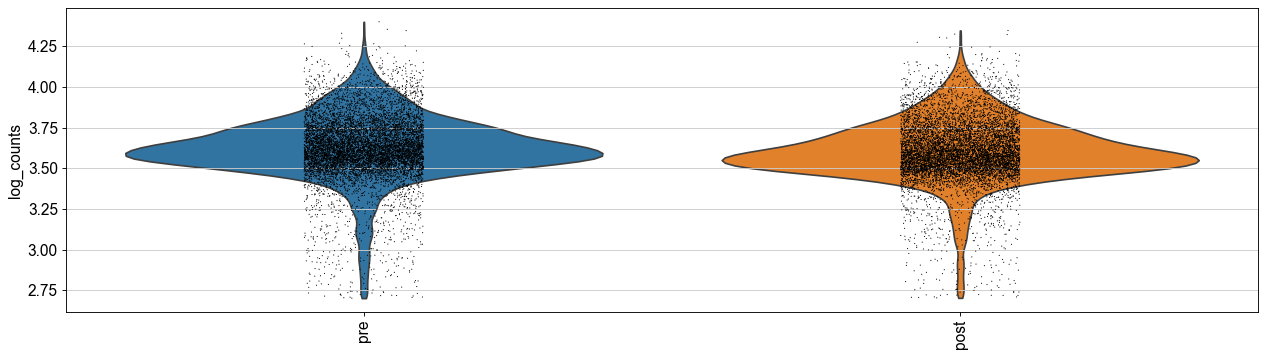

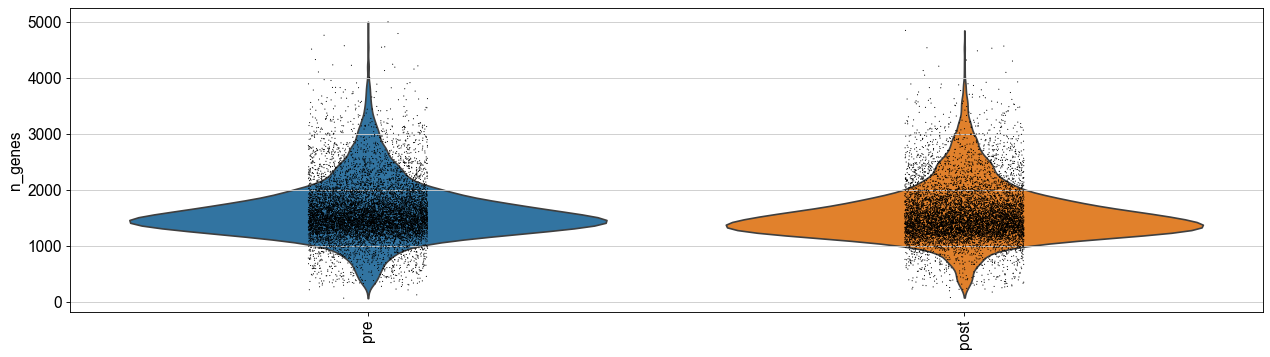

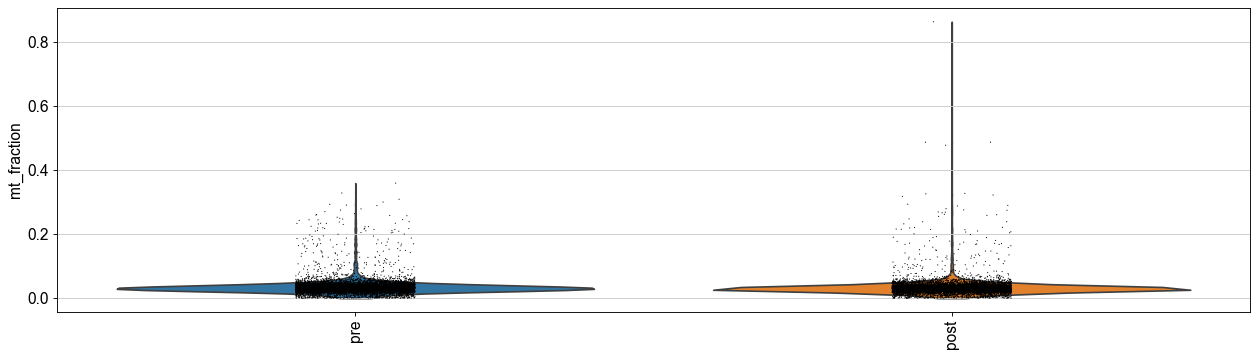

In [7]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='state', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='state', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='state', size=1, log=False, rotation=90)

<Axes:title={'center':'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

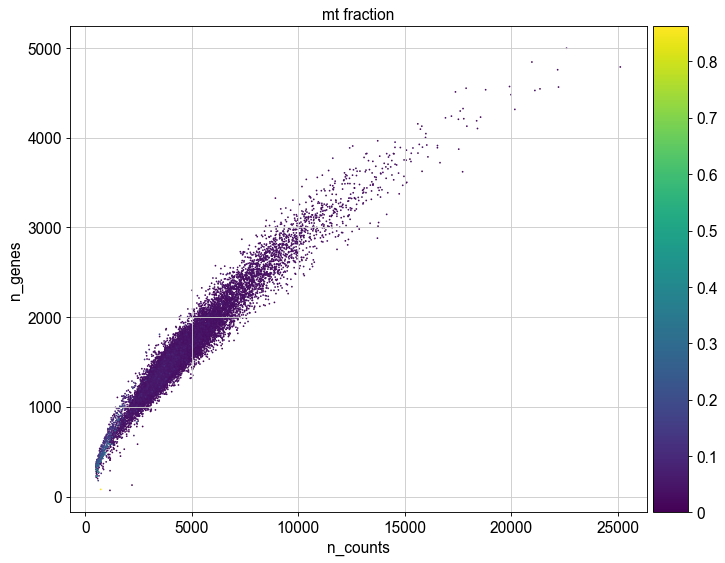

In [8]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes:title={'center':'state'}, xlabel='n_counts', ylabel='n_genes'>

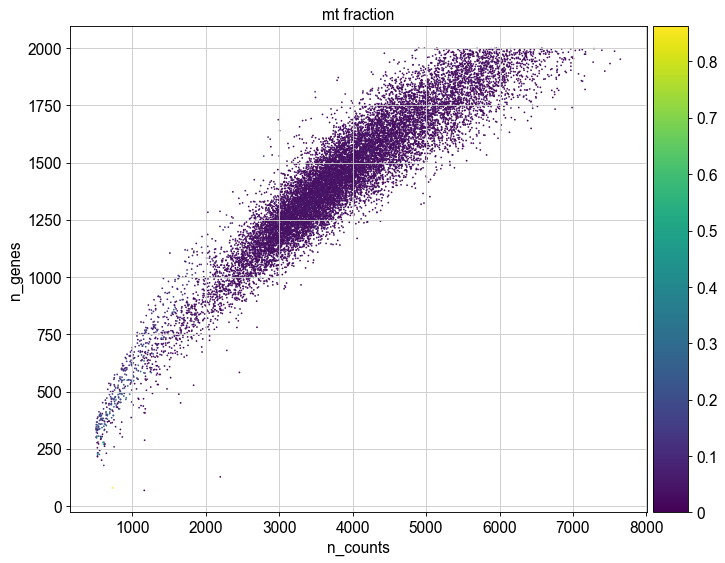

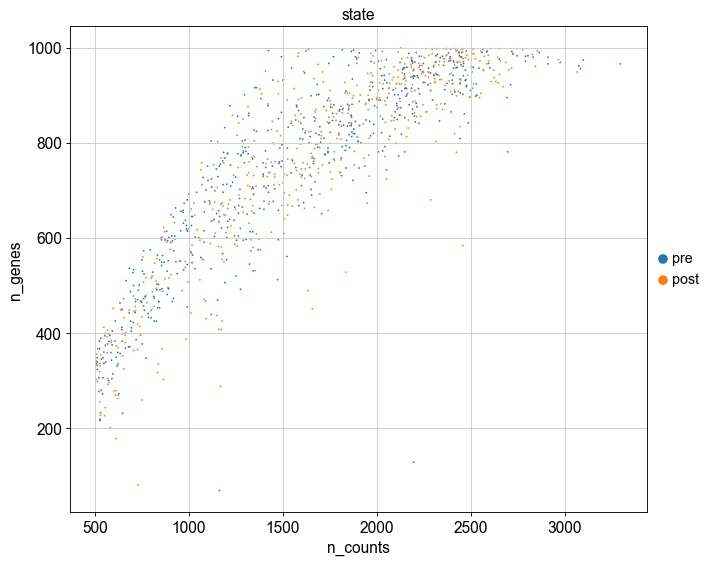

In [9]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='state', size=10, show=False)

## Cell Filtering

Filter cells by the following indicators:
- fraction of mitochondrial genes (max)
- gene count (min, max)
- gene count (max)

Filter genes by:
- amount of cells representing this gene (min)


Mitochondrial filter: The fraction of mt genes to all genes is high for cell with membrane leakage.

In [10]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.1  #todo why this value
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 18115
Number of cells after MT filter: 17841


Gene-Count Filter between 1000 and 10.000

In [11]:
low_count = adata_tmp.obs['n_counts'] > 1000
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')

sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximum filter: {adata_tmp.n_obs}')

filtered out 468 cells that have more than 10000 counts
Trying to set attribute `.obs` of view, copying.


Number of cells after minimum count filter: 17750
Number of cells after maximum filter: 17282


Gene-Count Filter: filter out cells with low gene count < 500

In [12]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 17266


Gene-Filter: filter out genes that are represented in less than 10 cells

In [13]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of genes after gene filter: {adata_tmp.n_vars}')

filtered out 20192 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


Number of genes after gene filter: 16409


## QC after filtering

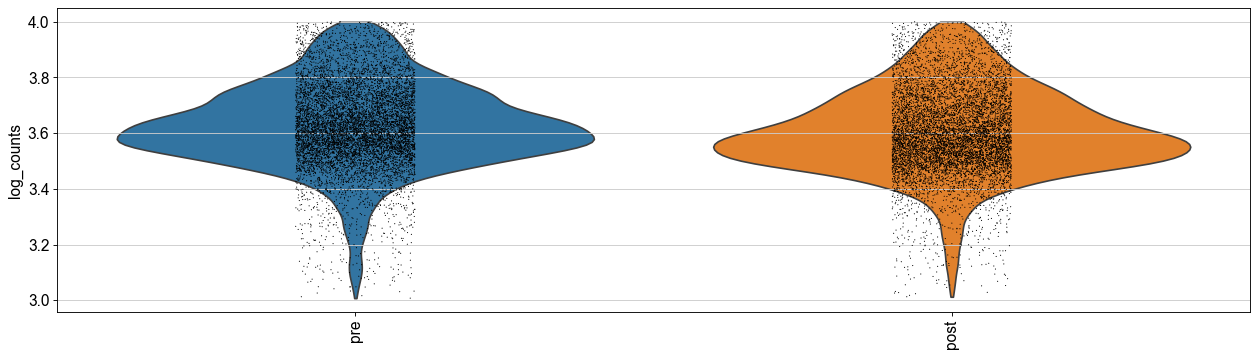

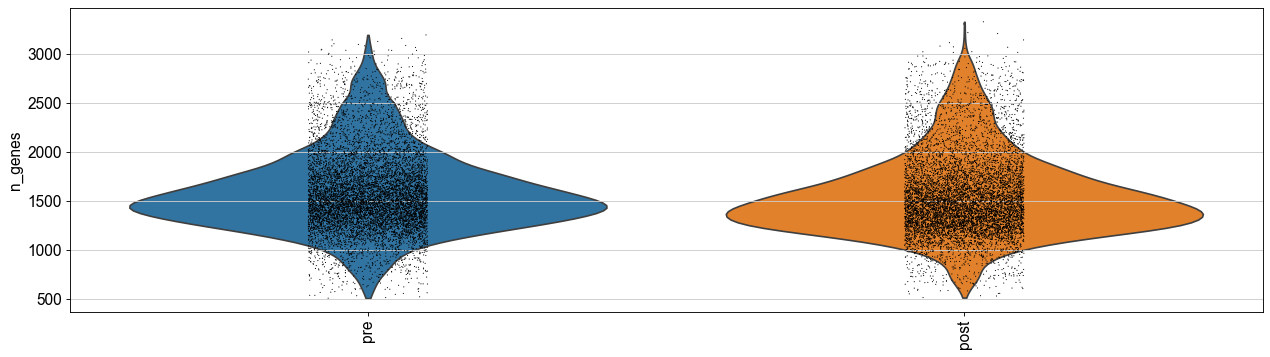

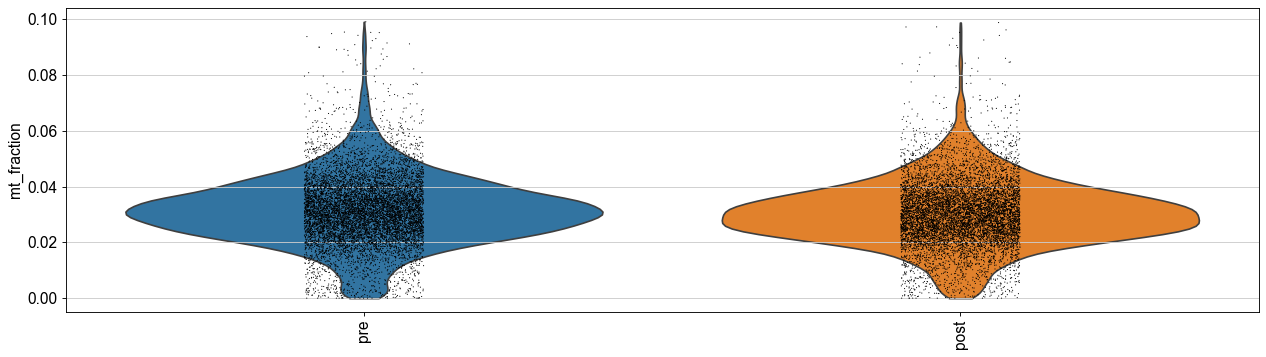

In [14]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='state', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='state', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='state', size=1, log=False, rotation=90)

In [15]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'state']]
df_all = pd.DataFrame(df.groupby(by='state')['n_genes'].apply(np.mean).values, 
                      index=df.groupby(by='state')['n_genes'].apply(np.mean).index, 
                      columns=['mean_genes'])

df_all['median_genes'] = df.groupby(by='state')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='state')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='state')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
state,,,,
pre,1591.599161,1521.0,4515.294434,4154.5
post,1549.103767,1469.0,4277.896973,3860.5


## Simple normalization


In [16]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata_tmp)

normalizing counts per cell
    finished (0:00:00)


In [17]:
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='state')
print('Shape before: ', adata_tmp.shape)
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
print('Shape after: ', adata_tmp.shape)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
C:\Users\felix.drost\Anaconda3\envs\mvtcr_4\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Shape before:  (17266, 16409)
Shape after:  (17266, 5000)


### Filter based on full receptor

In [18]:
print('Total cells: ', len(adata))
adata = adata[adata.obs['IR_VDJ_1_cdr3']!='nan']
adata = adata[adata.obs['IR_VDJ_1_cdr3']!='None']
print('With beta chain: ', len(adata))
adata = adata[adata.obs['IR_VJ_1_cdr3']!='nan']
adata = adata[adata.obs['IR_VJ_1_cdr3']!='None']
print('And alpha chain: ', len(adata))

Total cells:  18115
With beta chain:  16728
And alpha chain:  16701


In [19]:
sc.write(adata=adata_tmp, filename=path_filtered)

## Model Specific Preproccessing


### Embed Proteins

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [20]:
import sys
sys.path.append('../')
import tcr_embedding.utils_preprocessing as utils

In [21]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
adata.uns['aa_to_id'] = aa_to_id

Trying to set attribute `.uns` of view, copying.


In [22]:
alpha_length = adata.obs['IR_VJ_1_cdr3'].apply(lambda x: len(x)).max()
beta_length = adata.obs['IR_VDJ_1_cdr3'].apply(lambda x: len(x)).max()

max_length = max(alpha_length, beta_length)
max_length

28

In [23]:
utils.aa_encoding(adata, read_col='IR_VJ_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)
utils.aa_encoding(adata, read_col='IR_VDJ_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)

In [24]:
adata.obsm['alpha_seq']

array([[ 2, 14, 14, ...,  0,  0,  0],
       [ 2, 11, 14, ...,  0,  0,  0],
       [ 2, 14, 14, ...,  0,  0,  0],
       ...,
       [ 2,  2, 16, ...,  0,  0,  0],
       [ 2, 16, 16, ...,  0,  0,  0],
       [ 2,  6, 17, ...,  0,  0,  0]])

In [25]:
adata.write_h5ad(path_anno)

# Umap

In [26]:
adata = sc.read(path_filtered, compression='gzip')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:03)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


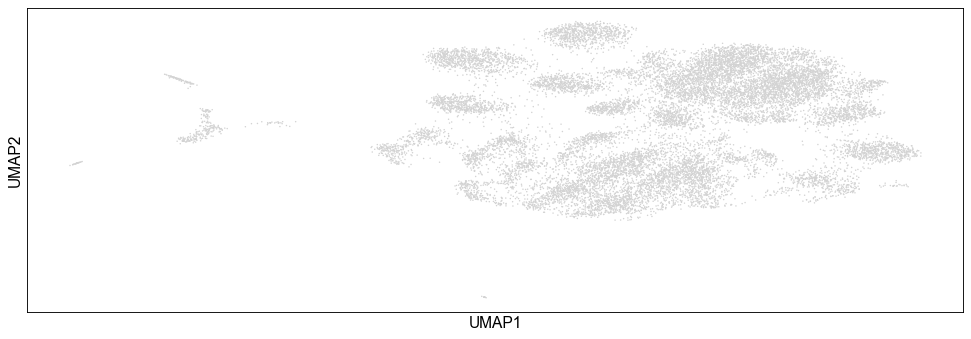

In [27]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

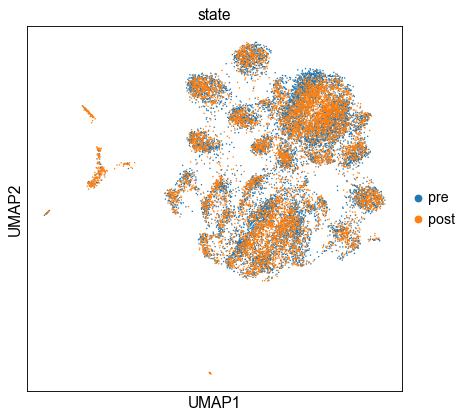

In [29]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color='state')